<a href="https://colab.research.google.com/github/Ritwik-1/Fine-Tune-SAM/blob/master/Adrenal_Dice_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Segmentations are only for the venous part

In [3]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.2 MB/s eta 0:00:00


In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

In [4]:
import pydicom

In [2]:
import os
import cv2
import torch
import numpy as np
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

model_checkpoint = "/content/drive/MyDrive/Colab Notebooks/assets/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint = model_checkpoint)
sam.to(device)

from segment_anything import SamPredictor

predictor = SamPredictor(sam)

In [9]:
def window_image(img, window_center,window_width,intercept,slope ,rescale=True):
    img = (img*slope +intercept) #for translation adjustments given in the dicom file.

    window_center = 50
    window_width = 350

    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    if rescale:
        img = (img - img_min) / (img_max - img_min)*255.0
    return img

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue: return int(x[0])
    else: return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

(512, 512)


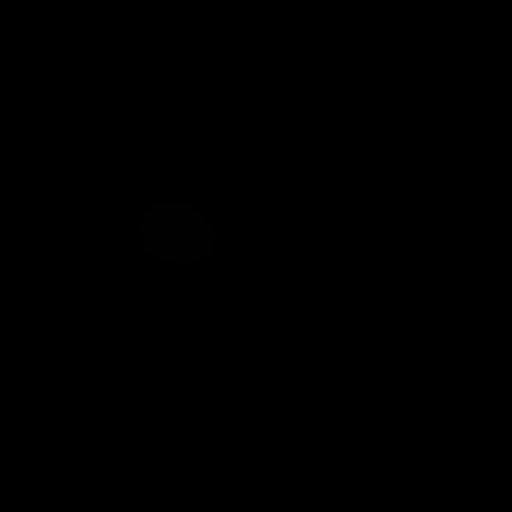

In [30]:
# PATIENT 1

abd_venous_path_P1 = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_001/08-22-2000-NA-CT ABDOMEN-56266/5.000000-Abd Venous 5.0 B40f-94387"

abd_venous_files_P1 = os.listdir(abd_venous_path_P1)
# print("No. of images : ",len(abd_venous_files_P1))

# seg_folder_path = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_001/08-22-2000-NA-CT ABDOMEN-56266/300.000000-Segmentation-33545"

seg_folder_path = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg/Adrenal_Ki67_Seg_001/08-22-2000-NA-CT ABDOMEN-56266/300.000000-Segmentation-33545/1-1.dcm"

# seg_file_name = os.listdir(seg_folder_path)[0]
# # print(seg_file_name)
# seg_file_path = os.path.join(seg_folder_path,seg_file_name)
# seg_file = pydicom.dcmread(seg_file_path)
# seg_array = seg_file.pixel_array

seg_array_2 = pydicom.dcmread(seg_folder_path).pixel_array
print(seg_array_2[29].shape)
cv2_imshow(seg_array_2[29])

# print(seg_array[29].shape)
# cv2_imshow(seg_array[29])

i = 0

for file in abd_venous_files_P1:
    break
    file_path = os.path.join(abd_venous_path_P1,file)
    dcm_file = pydicom.dcmread(file_path)
    array = dcm_file.pixel_array

    window_center , window_width, intercept, slope = get_windowing(dcm_file)
    array = window_image(array, window_center, window_width, intercept, slope, rescale = True)
    array = array.astype(np.uint8)
    array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)

    # seg_for_this = seg_array[i]
    print(i)
    # window_center , window_width, intercept, slope = get_windowing(seg_file)
    # seg_for_this = window_image(seg_for_this, window_center, window_width, intercept, slope, rescale = True)
    # seg_for_this = seg_for_this.astype(np.uint8)
    # seg_for_this = cv2.cvtColor(seg_for_this, cv2.COLOR_BGR2RGB)

    cv2_imshow(array)
    print(array.shape)
    cv2_imshow(seg_array[i])
    # print(seg_for_this.shape)
    # print(type(seg_for_this))
    i+=1
# print("No. of segmentations : ",seg_array.shape[0])


In [ ]:
CT_Images = []
Seg_Labels = []
Bounding_Boxes = []

In [ ]:
# for each patient take venous images and segmentations and bounding boxes
# 10 patients now and around 1k images
# superimpose image + provided seg and image + sam seg

above_patients_path = "/content/drive/MyDrive/manifest-1680809675630/Adrenal-ACC-Ki67-Seg"

patients = os.listdir(above_patients_path)

for patient in patients:
    print("Patient ID : ",patient)
    # patient = Adrenal_Ki67_Seg_001
    patient_folder_path = os.path.join(above_patients_path,patient)

    # patient folder = 08-22-2000-NA-CT ABDOMEN-56266
    patient_folder = os.listdir(patient_folder_path)[0]

    patient_filesfolder_path = os.path.join(patient_folder_path,patient_folder)

    # patient_filesfolder is the list which has 2-3 folders which
    # are the venous,non-venous,segmentation etc
    patient_filesfolder = os.listdir(patient_filesfolder_path)

    print("Folders :-")
    for folder in patient_filesfolder:
      print(folder)
    print()




Patient ID :  Adrenal_Ki67_Seg_051
Folders :-
401.000000-ABD AX ART iDose 4-12159
300.000000-Segmentation-43028

Patient ID :  Adrenal_Ki67_Seg_052
Folders :-
302.000000-ABD AX 1.25 PRE-17123
20.000000-ABD PEL AX 1.25 DEL 15-01130

Patient ID :  Adrenal_Ki67_Seg_046
Folders :-
300.000000-Segmentation-68934
4.000000-No series description-14573

Patient ID :  Adrenal_Ki67_Seg_047
Folders :-
300.000000-Segmentation-06609
2.000000-ABDPELV SFT TISSUE 3X3-62201

Patient ID :  Adrenal_Ki67_Seg_053
Folders :-
12.000000-ABD AX 3 DEL-25085
7.000000-ABD AX 3 PV-01373
300.000000-Segmentation-13639
3.000000-ABD AX 3 PRE-55155

Patient ID :  Adrenal_Ki67_Seg_048
Folders :-
2.000000-NA-94141
300.000000-Segmentation-72337

Patient ID :  Adrenal_Ki67_Seg_050
Folders :-
300.000000-Segmentation-70908
201.000000-ABDOMENPELVIS W iDose 3-36045

Patient ID :  Adrenal_Ki67_Seg_045
Folders :-
2.000000-CHESTABD WITH-35882
6.000000-DELAY-18500
300.000000-Segmentation-11611

Patient ID :  Adrenal_Ki67_Seg_049
Fol